In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


# First we read the csv with the encoding ISO-8859-1 because it has special characters 

In [2]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding='ISO-8859-1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## I see that it doesn't have a column name so I re-read the csv adding a name to the columns

In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding='ISO-8859-1',names=['feeling', 'id', 'date', 'query', 'user', 'tweet'])
df.head()

,feeling,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## I check if there is missing data

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   feeling  1600000 non-null  int64 
 1   id       1600000 non-null  int64 
 2   date     1600000 non-null  object
 3   query    1600000 non-null  object
 4   user     1600000 non-null  object
 5   tweet    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## I check if there data is balanced

In [31]:
class_counts = df['feeling'].value_counts()
print(class_counts)

0    800000
4    800000
Name: feeling, dtype: int64


## I identify the most common words for each sentiment

In [39]:
from nltk.tokenize import word_tokenize
from collections import Counter
train_pos_0 = df[df['feeling'] == 0]
target_0_df = train_pos_0['tweet']
train_pos = df[df['feeling'] == 4]
target_4_df = train_pos['tweet']

def count_most_common_words(dataframe, n):
    words = ' '.join(dataframe)
    all_tweets = " ".join(words.split())
    words = word_tokenize(all_tweets)
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(n)
    return most_common_words

most_common_words_target_0 = count_most_common_words(target_0_df, 10)  
most_common_words_target_4 = count_most_common_words(target_4_df, 10)  

print("Palabras más frecuentes para target 0:", most_common_words_target_0)
print("Palabras más frecuentes para target 4:", most_common_words_target_4)

Palabras más frecuentes para target 0: [('.', 444709), ('!', 385230), ('I', 381544), ('@', 321883), ('to', 308860), ('the', 242017), (',', 224293), ('i', 185857), ('a', 176342), ('my', 168250)]
Palabras más frecuentes para target 4: [('!', 532720), ('@', 476799), ('.', 380991), ('I', 267090), (',', 260173), ('to', 248402), ('the', 247625), ('a', 191021), ('you', 174044), ('and', 137566)]


## Since the most common token were punctuation mark I decide to tokenize only words using stopwords

In [5]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

def count_most_common_words(dataframe, n):
    words = ' '.join(dataframe)
    all_tweets = " ".join(words.split())
    words = word_tokenize(all_tweets)
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(n)
    return most_common_words

df['clean_tweet'] = df['tweet'].apply(clean_text)

most_common_words_target_0 = count_most_common_words(df[df['feeling'] == 0]['clean_tweet'], 20)
most_common_words_target_4 = count_most_common_words(df[df['feeling'] == 4]['clean_tweet'], 20)
print("Palabras más frecuentes para target 0:", most_common_words_target_0)
print("Palabras más frecuentes para target 4:", most_common_words_target_4)

Palabras más frecuentes para target 0: [('get', 45416), ('go', 45268), ('work', 44591), ('like', 40765), ('day', 38505), ('got', 38444), ('today', 37217), ('going', 33545), ('back', 32681), ('ca', 31830)]
Palabras más frecuentes para target 4: [('good', 61376), ('love', 47208), ('http', 47139), ('quot', 45931), ('day', 44880), ('like', 37224), ('get', 36352), ('lol', 34380), ('thanks', 34088), ('got', 31866)]


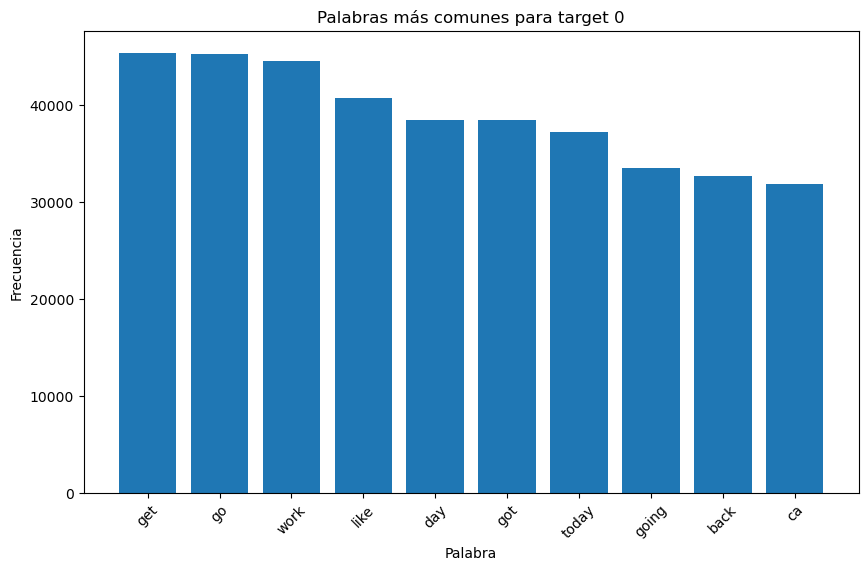

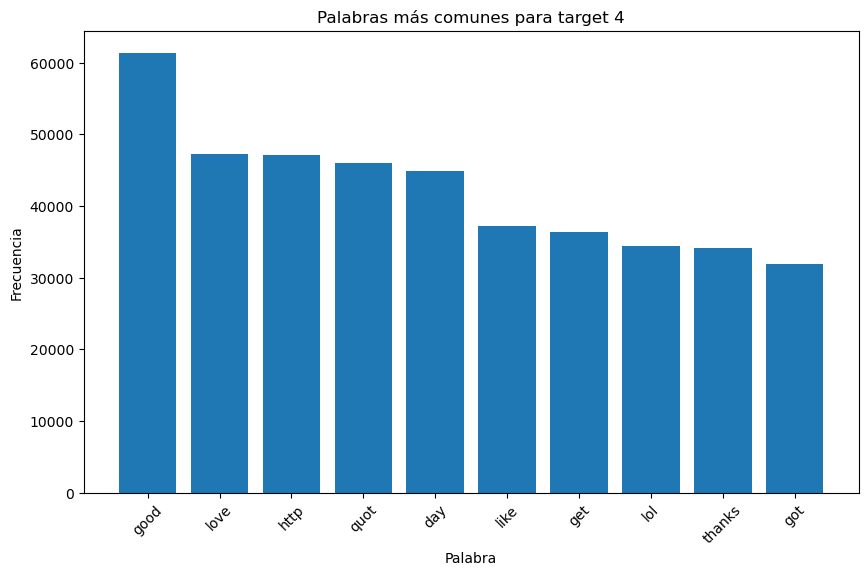

In [6]:
import matplotlib.pyplot as plt

def plot_word_frequencies(words_list, title):
    words, frequencies = zip(*words_list)
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_word_frequencies(most_common_words_target_0, 'Palabras más comunes para target 0')
plot_word_frequencies(most_common_words_target_4, 'Palabras más comunes para target 4')
